In [1]:

# imports

import yfinance as yf
import pandas as pd
import datetime as dt
import kingquant as kq
import seaborn as sns
from  matplotlib import pyplot as plt
from scipy import stats
import warnings


warnings.filterwarnings('ignore')

print('This notebook was refreshed at %s'%(dt.datetime.now()))

sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, 
            rc={'figure.figsize':(15,10)})

pd.options.display.float_format = '{:,.2f}'.format
df_port=pd.read_csv('../data/share/qqq_holdings.csv')


ticker_list=['QQQ','SPY','SPLV','MCHI','GLD','TLT','GSG','VNQ','BTC-USD','SHY','KWEB','2822.HK','LQD']
display=['QQQ','SPLV','GLD','TLT','SPY'] # to simply chart for easier reading
focus='QQQ' # to simply chart for correlation
start_date=dt.date(2000,1,1)
end_date=dt.date.today()
recent=3*365 # period in days for stats of recent data
horizon=10*365 # period in days for time horizon in charts

This notebook was refreshed at 2022-10-11 20:14:39.961133


In [2]:
df_stock=kq.get_port_holding_info(df_port)
df_stock.to_csv('../data/share/qqq_holidngs_info.csv') # cache the data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [3]:

#Calcuate metric of QQQ holdings

#df_stock=pd.read_csv('../data/share/qqq_holidngs_info.csv')
df_metric=kq.get_port_holding_metric(df_stock)
df_metric.reindex(columns=['ticker','weight','price','drawdown','1w_chg_pct','pcf','pe_ttm','eps_ttm',
                'pe_fwd','fwd_eps','est_eps_growth','peg','roe','cf_margin','net_margin'])\
                .sort_values(by='pe_fwd',ascending=True)\
                .style.format(precision=2,thousands=',',formatter={'weight':'{:.3f}',
                                                                    'drawdown':'{:.1f}%',
                                                                    'est_eps_growth':'{:.1f}%',
                                                                    'gross_margin':'{:.1f}%',
                                                                    'cf_margin':'{:.1f}%',
                                                                    'net_margin':'{:.1f}%',

                                                                
                                                                
                                                                    
                                                                    })

df_port_metric=kq.get_port_metric(df_metric)
qqq_price=yf.Ticker('QQQ').info['regularMarketPrice']
qqq_fundations={}
qqq_fundations['Price']=qqq_price
units=df_port_metric['market_cap']/qqq_price
qqq_fundations['EPS']=df_port_metric['net_income']/units
qqq_fundations['Forward EPS']=qqq_fundations['EPS']*(1+df_port_metric['fwd_income_growth'])
qqq_fundations['PE']=qqq_price/qqq_fundations['EPS']
qqq_fundations['Forward PE']=df_port_metric['fwd_pe']
qqq_fundations['Foward Earning Growth']=df_port_metric['fwd_income_growth']
qqq_fundations['Forward Revenue Growth']=df_port_metric['revenue_growth']


#get rate data
period=365*40 
df_rate=pd.DataFrame()
data=yf.download(['^IRX','^FVX','^TNX','^TYX'],progress=False)

df_rate=data.loc[dt.date.today()-dt.timedelta(days=period):]['Close']
df_rate.columns=['13 Weeks','5 Years','10 Years','30 Years']
s=df_rate.tail(1).style.format('{:.3f}%')



# price change info
df_price_change=pd.DataFrame()
for ticker in ticker_list:
    try:
        price_info=kq.get_price_change(ticker)
        df_price_change=df_price_change.append(price_info,ignore_index=True)
    except:
        pass


# price history
df_price=pd.DataFrame() 

for ticker in ticker_list:
    data=yf.download(ticker,start_date,end_date,auto_adjust=True,progress=False)
    price=data.Close
    df_price[ticker]=price

#daily return stat
df_return=df_price.pct_change()
df_return_stat=pd.DataFrame()
for ticker in ticker_list:
	df_return_stat[ticker]=df_return[ticker].describe()
    
df_return_stat=df_return_stat.T

df_return_stat['mean_annualized']=df_return_stat['mean']*250
df_return_stat['std_annualized']=df_return_stat['std']*250**0.5

df_return_recent=df_return[end_date-dt.timedelta(days=recent):]
df_recnet_return_stat=df_return_recent.describe().T
df_recnet_return_stat['mean_annualized']=df_recnet_return_stat['mean']*250
df_recnet_return_stat['std_annualized']=df_recnet_return_stat['std']*250**0.5

#1 year rolling return
df_return_roll_actual=df_price/df_price.shift(250)-1


In [4]:

#Calcuate Correlation
df_return_cov=df_price.resample('1W').last().pct_change().dropna()
df_cov=pd.DataFrame()

for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        df_cov[ticker1+'_'+ticker2]=kq.cal_rolling_cov(df_return_cov[ticker1],df_return_cov[ticker2],365)

df_cov_365d=pd.DataFrame(index=ticker_list)
for ticker1 in ticker_list:
    for ticker2 in ticker_list:
        df_cov_365d.loc[ticker1,ticker2]=df_cov[ticker1+'_'+ticker2].iloc[-1]


In [ ]:
#data playground

df_stock.to_csv('qqq_holdings_info.csv')

 # 以QQQ为核心的资产配置研究
历史数据表明股票是长期收益最高的资产类别之一，而QQQ（纳斯达克100指数）基本可以代表全球市值最大的100家科技公司，是最适合长期投资的股票指数ETF。因为：
1. 科技是推动生产力发展的核心要素，科技公司有更好的长期成长性，预期收益率高于整个市场。
2. 大型科技公司的盈利能力很强。
3. 大型科技公司有规模优势，集中了大量的优秀人才和资源，强者恒强。

然而，长期持有QQQ的风险（波动率）是比较高的。历史上，曾经有.com泡沫破灭纳指下跌90%的大崩盘。尽管今天的纳指1和2000年时期的纳指主要成份股及其盈利能力有很大不同了，但是整体上QQQ的波动还是比较大，超过了我的风险承受能力。为了降低波动，通过配置和QQQ相关度不高的其他类资产，可以拉平波动同时不损失太多的预期收益率。

因此，我的长期资产配置逻辑是：
1. 确定QQQ的配置比例：这是资产配置的核心，在30%～60%区间浮动。这里的核心逻辑是根据QQQ的估值来确定仓位。
2. 确定剩余资金的资产配置：这部分的配置逻辑是对冲QQQ的波动又不牺牲太多的长期收益。这部分的核心逻辑是考了其它资产和QQQ的相关度以及预期收益率。


## QQQ估值计算

估值方法上，可以采取未来1年FW EPS * FW PE来计算。这些都是预测值，预测需要考虑经济周期对EPS的影响，考虑利率周期（资本流动）、经济周期（增长速度）对估值倍数的影响。

### QQQ FW EPS 计算

FW EPS采取分析师对成份股公司的一致性预期为基础进行计算。
1. 收集每一家成份股的市值、TTM EPS、FW EPS
2. 通过总市值/当前价格计算unit
3. 加总所有FW EPS/unit 计算FW EPS
4. 加总所有TTM EPS计算增长率
5. 同样方法计算营收增长率
6. 计算利润率、毛利率作为参考指标


QQQ基本面数据如下：

In [5]:
df_qqq=pd.DataFrame.from_dict(qqq_fundations,orient='index',columns=['QQQ'])
df_qqq

,QQQ
Price,262.75
EPS,10.96
Forward EPS,13.93
PE,23.96
Forward PE,18.87
Foward Earning Growth,0.27
Forward Revenue Growth,0.09


In [6]:
qqq_fw_eps=df_qqq.loc['EPS']*1.09
qqq_fw_eps

QQQ   11.95
Name: EPS, dtype: float64

## QQQ估值倍数的确定

QQQ估值倍数通过参考一些数据，主观确定，每个季度更新。影响PE倍数的因素包括：
1. 资金流向。资金流出股市时，股市估值水平下降；资金流入股市时，估值水平上升。影响股市资金流向的首要因素是美联储的利率政策：加息周期中，会有更多资金流入股市，推高估值，反之亦然。影响美联储利率政策的前瞻指标是CPI和失业率。另一方面，通过美联储AIAE指标可以观察股市在整个资本市场中的占比，对资金流向做一些判断。
2. 利润增长率。预期利润增长率也会影响估值倍数，增速越高估值水平越高。通过对经济周期的判断可以帮助判断利润增长率，也可以直接采用分析师一致性预期。

### 美国国债收益率

Text(0.5, 1.0, 'Trend of treasury yield')

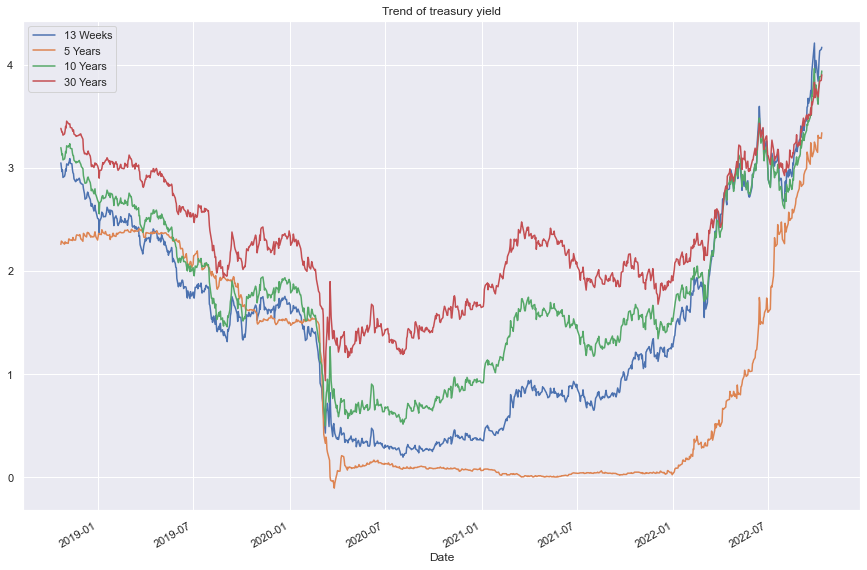

In [7]:
df_rate[-1000:].plot()
plt.title("Trend of treasury yield")

<AxesSubplot:>

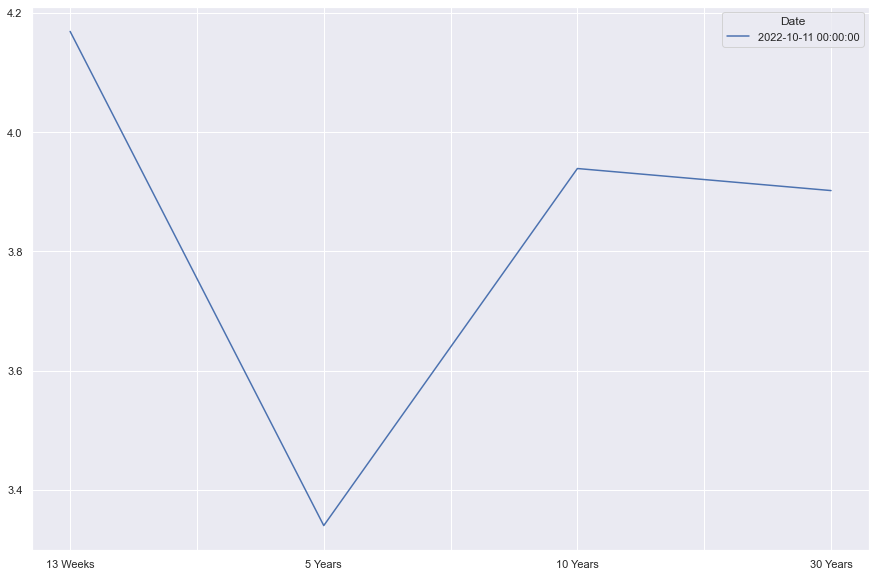

In [8]:
df_rate.tail(1).T.plot()

### US CPI

https://www.bls.gov/charts/consumer-price-index/consumer-price-index-by-category-line-chart.htm

### 大宗商品价格
石油和大宗商品的价格可以作为CPI的前瞻性指标。这里主要观察GSG的价格变化.

Text(0.5, 1.0, 'GSG Price Trend')

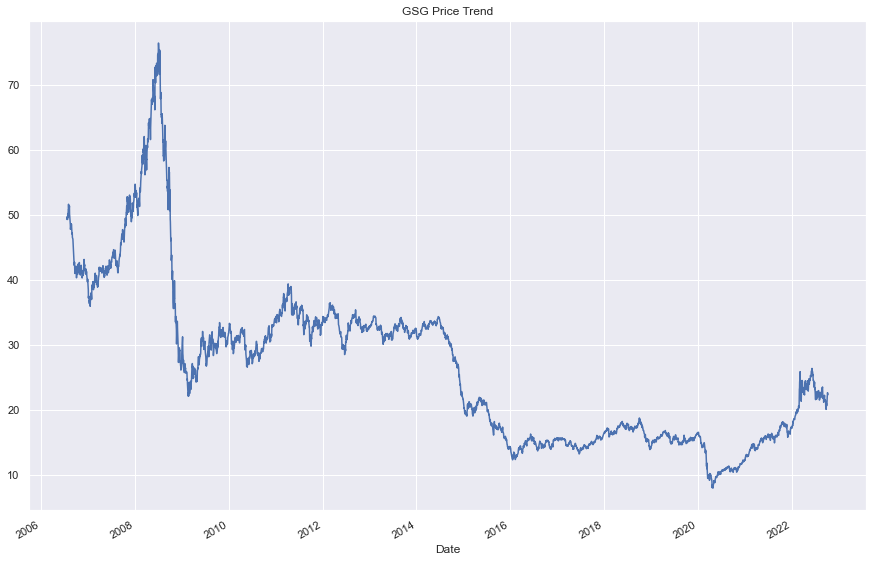

In [9]:
df_price['GSG'].plot()
plt.title('GSG Price Trend')

大宗商品价格已经开始回落，CPI通胀率较上个月有一些回落（9.1-8.5），CPI可能已经见顶，美联储的紧缩力度应该不会加码。但是CPI仍然在高位，未来一段时间美联储的紧缩政策不会改变。预期联邦基准利率的目标在3%左右，QQQ的风险溢价为3%（当利率为0的时候，QQQ的估值在33倍左右），则QQQ的合理PE为17倍。考虑到QQQ的仍然EPS有10%+的增长率，估值20倍为合理水平。

In [18]:
qqq_fw_pe=18
qqq_target_price=qqq_fw_eps*qqq_fw_pe
print('QQQ 目标价格:%d, 当前价格:%d, %f'%(qqq_target_price,qqq_price,qqq_price/qqq_target_price-1))

QQQ 目标价格:215, 当前价格:262, 0.221339


-15%～15% 合理
>15% 高估
<-15% 低估

## 其它资产的配置

在确定了QQQ的配置之后，下一个问题是剩余资金如何配置？这个问题的关键是判断各类资产的长期收益率及未来1年和QQQ的相关度。

首先看看，过去一段时间各类资产的收益和风险。

### 各类资产风险收益对比

In [11]:
df_price_change.set_index('ticker').sort_values(by='1w_chg_pct')

,last_price,1w_chg_pct,2w_chg_pct,1m_chg_pct,1y_chg_pct,drawdown,diff_to_60d_avg,diff_to_200d_avg
ticker,,,,,,,,
KWEB,22.57,-14.15,-10.65,-22.28,-51.54,-54.70,-18.72,-25.36
2822.HK,12.73,-9.33,-3.71,-11.47,-29.55,-33.25,-11.14,-17.92
MCHI,40.64,-8.69,-6.83,-17.16,-40.36,-43.39,-15.02,-23.10
VNQ,77.49,-6.92,-3.16,-19.03,-22.38,-31.68,-15.22,-20.70
QQQ,262.75,-6.87,-4.27,-15.29,-26.23,-34.56,-12.56,-18.25
BTC-USD,"19,077.87",-5.37,-1.80,-14.72,-65.96,-71.76,-5.92,-29.09
SPY,357.74,-5.35,-1.55,-12.59,-16.46,-24.25,-9.47,-13.55
SPLV,57.60,-4.48,-2.46,-11.63,-4.49,-16.27,-8.29,-9.57
TLT,99.86,-3.55,-0.84,-6.82,-28.04,-34.18,-9.60,-17.71


Text(0.5, 1.0, 'Historical Rolling 1 Year Return')

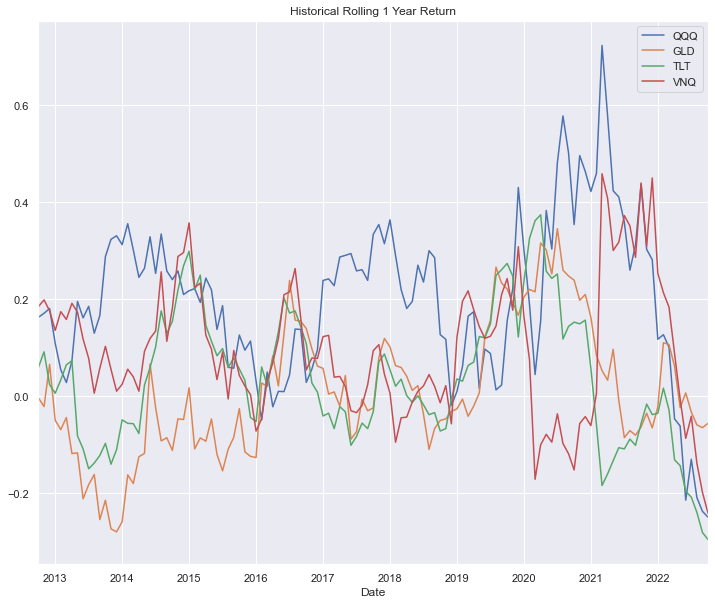

In [14]:
display=['QQQ','GLD','TLT','VNQ'] # to simply chart for easier reading
df_return_roll_actual.resample('M').last().loc[(end_date-dt.timedelta(days=horizon)):][display].plot(figsize=(12,10))
plt.title('Historical Rolling 1 Year Return')

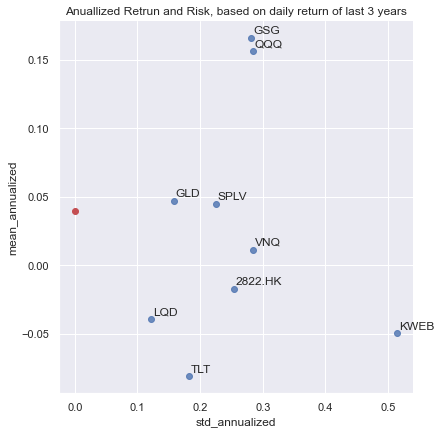

In [15]:
riskfree=0.04
display=['QQQ','GLD','TLT','GSG','2822.HK','SPLV','KWEB','VNQ','LQD'] # to simply chart for easier reading
sns.lmplot(x='std_annualized',y='mean_annualized',data=df_recnet_return_stat.loc[display],ci=None,height=6,fit_reg=False)
plt.title('Anuallized Retrun and Risk, based on daily return of last %i years'%(recent/365))
#plot text
for i in range(df_recnet_return_stat.loc[display].shape[0]):
    plt.text(x=df_recnet_return_stat.loc[display]['std_annualized'][i]+0.003,y=df_recnet_return_stat.loc[display]['mean_annualized'][i]+0.003,s=df_recnet_return_stat.loc[display].index[i]
          )
plt.plot(0,riskfree,'ro')

从上述数据可以得出，QQQ是风险收益比最好的资产之一。REIT的长期收益也不错。债券、黄金的风险收益比很差。GSG长期收益是负的。比特币的风险收益比也不错但是风险太高。现阶段，TLT和QQQ处于十年来收益最差的时期，很可能处于筑底阶段。从经济和股市的周期性看，现在可能是长期布局QQQ和TLT的好时机，但是准确判断周期是极其困难的。

资产的配置，除了风险收益方面的考虑，另一个很重要的因素就是和QQQ的相关度。

### 各类资产相关度分析

In [16]:
print('365 day correlation based on weekly return')
df_cov_365d


365 day correlation based on weekly return


,QQQ,SPY,SPLV,MCHI,GLD,TLT,GSG,VNQ,BTC-USD,SHY,KWEB,2822.HK,LQD
QQQ,1.00,0.97,0.73,0.37,0.07,0.04,0.11,0.77,0.53,0.14,0.31,0.06,0.48
SPY,0.97,1.00,0.83,0.35,0.14,0.01,0.21,0.83,0.53,0.22,0.29,0.05,0.48
SPLV,0.73,0.83,1.00,0.21,0.18,0.15,0.22,0.90,0.31,0.37,0.14,0.07,0.47
MCHI,0.37,0.35,0.21,1.00,0.05,0.04,0.08,0.20,0.20,0.01,0.95,0.65,0.25
GLD,0.07,0.14,0.18,0.05,1.00,-0.02,0.54,0.25,0.28,0.11,-0.04,0.31,0.03
TLT,0.04,0.01,0.15,0.04,-0.02,1.00,-0.11,0.25,0.04,0.46,-0.03,0.10,0.79
GSG,0.11,0.21,0.22,0.08,0.54,-0.11,1.00,0.13,0.19,0.18,0.03,0.06,0.04
VNQ,0.77,0.83,0.90,0.20,0.25,0.25,0.13,1.00,0.45,0.36,0.11,0.12,0.57
BTC-USD,0.53,0.53,0.31,0.20,0.28,0.04,0.19,0.45,1.00,-0.17,0.15,0.01,0.21
SHY,0.14,0.22,0.37,0.01,0.11,0.46,0.18,0.36,-0.17,1.00,-0.05,0.07,0.57


Text(0.5, 1.0, '365 Days Correlation based on weekly return')

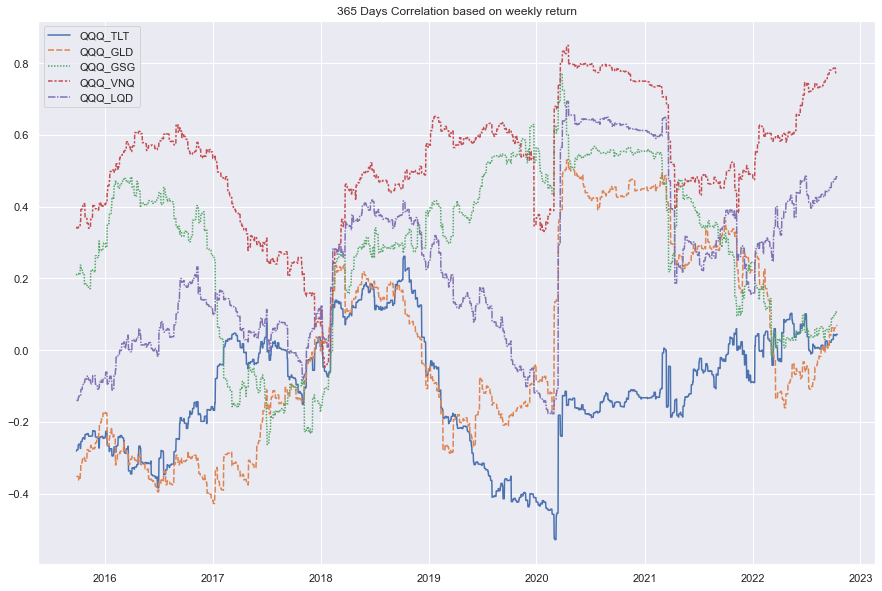

In [17]:
col=['QQQ_TLT','QQQ_GLD','QQQ_GSG','QQQ_VNQ','QQQ_LQD']
df_cov_filtered=df_cov[col]
plot=sns.lineplot(data=df_cov_filtered.loc[dt.date.today()-dt.timedelta(days=365*10):])
plt.title('365 Days Correlation based on weekly return')

从上图可以看出，各类资产之间的相关度变化是非常大的，并不存在一个永远最佳的配置方案。
资产配置上可以采取两个思路：

1. 简单一点，各类资产按一个固定的比例长期配置，定期再平衡，通过再平衡的被动交易来实现低买高卖。考虑到QQQ已经是动态调整了，因此其它资产可以考虑如下配置：10%黄金，5%数字货币，15% TLT, 剩余的部分现金。该配置的优点是简单，避免认为判断错误带来的损失。缺点是当某类资产出现很明显的下跌或上涨趋势的时候，无法利用这个趋势获得超额收益。

2. 通过对经济周期的判断来优化资产配置。这个方案的难点是对于经济周期的把握以及对不同经济周期下资产表现的预判。要判断准很难。



